# seq2seq之文本摘要任务
- 同样是一个 Seq2Seq 任务，旨在尽可能保留文本语义的情况下将长文本压缩为短文本。
- 摘要可以看作是将长文本“翻译”为捕获关键信息的短文本，因此大部分文本摘要模型同样采用 Encoder-Decoder 框架。
- 也有一些非 Encoder-Decoder 框架的摘要模型，例如 GPT 家族也可以通过小样本学习 (few-shot) 进行文本摘要。
  - few-shot learning（小样本学习）
    - 模型在不重新训练、不更新参数的情况下，只通过给它少量“示例”，就学会在当前任务上该怎么做。
    - 不是训练方法，而是在推理用法，推理时利用模型的已有知识，通过few-shot的方式进行文本摘要。
    - 在本质上，GPT没有“学习”摘要这个任务，GPT 并不是“临时学会了摘要”，而是通过“识别”出你在做摘要这种模式，从而“学会”如何进行摘要。

  | 名称           | 给模型什么     | 举例          |
  | ------------ | --------- | ----------- |
  | zero-shot    | 只有任务指令    | “请总结下面的文章”  |
  | **few-shot** | 指令 + 几个示例 | “原文 → 摘要”×3 |
  | fine-tuning  | 大量标注数据    | 真正训练模型      |

    - GPT 通过 few-shot 实现文本摘要，并不是因为它“学会了摘要任务”，而是因为 Transformer 能在上下文中识别并拟合“长文本 → 压缩表达”的模式，这种能力被称为 in-context learning，使得 decoder-only 架构在无需 encoder-decoder 的情况下也能完成摘要任务。


## 常见的文本摘要模型
- GPT-2：虽然是自回归 (auto-regressive) 语言模型，但是可以通过在输入文本的末尾添加 TL;DR 来使 GPT-2 生成摘要；
- PEGASUS：与大部分语言模型通过预测被遮掩掉的词语来进行训练不同，PEGASUS 通过预测被遮掩掉的句子来进行训练。由于预训练目标与摘要任务接近，因此 PEGASUS 在摘要任务上的表现很好；
- T5：将各种 NLP 任务都转换到 text-to-text 框架来完成的通用 Transformer 架构，要进行摘要任务只需在输入文本前添加 summarize: 前缀；
- mT5：T5 的多语言版本，在多语言通用爬虫语料库 mC4 上预训练，覆盖 101 种语言；
- BART：包含一个 Encoder 和一个 Decoder stack 的 Transformer 架构，训练目标是重构损坏的输入，同时还结合了 BERT 和 GPT-2 的预训练方案；
- mBART-50：BART 的多语言版本，在 50 种语言上进行了预训练。

# 文本摘要实战
- 目标：微调一个多语言文本摘要模型用于完成中文摘要：为新浪微博短新闻生成摘要。
- 模型：mT5
    - T5 模型通过模板前缀 (prompt prefix) 将各种 NLP 任务都转换到 text-to-text 框架进行预训练
    - 例如摘要任务的前缀就是 summarize:，模型以前缀作为条件生成符合模板的文本，这使得一个模型就可以完成多种 NLP 任务：
    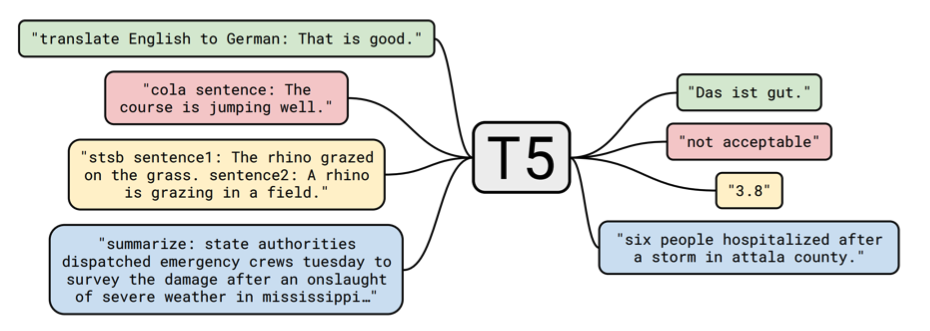
    - mT5 模型不使用前缀
- 数据集：该语料基于新浪微博短新闻构建，规模超过 200 万，将新闻标题作为摘要
    - 该语料已经划分好了训练集、验证集和测试集
    - https://www.heywhale.com/mw/dataset/5e6740a5f278cf002d5335b8
    - 标题和正文分开存储，比如对于train就是 train.src.txt 和 train.tgt.txt 中

    


# 1.数据处理与加载
- 按照数据格式进行dataset的构建
- 有限度加载数据集
- 数据预处理：按批次进行tokenizer
    - 对输入和标签进行并行分词
    - 对输入和标签进行padding

In [9]:
#dataset
from torch.utils.data import Dataset

max_size=10000

class LCSTS(Dataset):
    def __init__(self,file_path_src,file_path_tgt,max_size=max_size):
        self.file_path_src=file_path_src
        self.file_path_tgt=file_path_tgt
        self.max_size=max_size
        self.data=self.load_data(file_path_src,file_path_tgt)
        
    def load_data(self,file_path_src,file_path_tgt):
        Data={}
        with open(file_path_src, 'rt', encoding='utf-8') as f_src,open(file_path_tgt, 'rt', encoding='utf-8') as f_tgt:
            for idx, (line_src,line_tgt) in enumerate(zip(f_src,f_tgt)):
                if idx >= self.max_size:
                    break
                items_src = line_src.strip()
                items_tgt = line_tgt.strip()
                
                Data[idx] = {
                    'title': items_tgt,
                    'content': items_src
                }
        return Data

    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]
    


In [12]:
train_data = LCSTS('data/LCSTS/train.src.txt','data/LCSTS/train.tgt.txt')
#为了保护我的3060，只能降低样本量
val_data = LCSTS('data/LCSTS/valid.src.txt','data/LCSTS/valid.tgt.txt',max_size=1000)
test_data = LCSTS('data/LCSTS/test.src.txt','data/LCSTS/test.tgt.txt',max_size=1000)


In [13]:
print(f'train set size: {len(train_data)}')
print(f'val set size: {len(val_data)}')
print(f'test set size: {len(test_data)}')
print(next(iter(train_data)))

train set size: 10000
val set size: 1000
test set size: 1000
{'title': '修改后的立法法全文公布', 'content': '新华社受权于18日全文播发修改后的《中华人民共和国立法法》，修改后的立法法分为“总则”“法律”“行政法规”“地方性法规、自治条例和单行条例、规章”“适用与备案审查”“附则”等6章，共计105条。'}


分词器使用 BUET CSE NLP Group 提供的 mT5 摘要模型

In [15]:
#按批次加载数据集。转为模型可以读取的ids
from torch.utils.data import DataLoader
from transformers import AutoTokenizer

checkpoint = "csebuetnlp/mT5_multilingual_XLSum"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)





d:\software\Anaconda\envs\LLM\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ASUS\.cache\huggingface\hub\models--csebuetnlp--mT5_multilingual_XLSum. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokeniz

## Unigram 切分算法
- 基于字符的统计模型
- 利用字符出现的频率来构建一个字符的概率分布
- 对输入文本进行切分，使得切分后的子字符串在概率分布中出现的频率最高

In [17]:
#测试一下这个tokenizer
sen="马孔多在下雨"
inputs=tokenizer(sen)
print(inputs)
print(tokenizer.decode(inputs['input_ids']))
print(tokenizer.convert_ids_to_tokens(inputs['input_ids']))

{'input_ids': [259, 6890, 53569, 3139, 1083, 2446, 16189, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}
马孔多在下雨</s>
['▁', '马', '孔', '多', '在', '下', '雨', '</s>']


In [18]:
sen1="I am a student."
inputs1=tokenizer(sen1)

print(tokenizer.convert_ids_to_tokens(inputs1['input_ids']))

['▁I', '▁am', '▁', 'a', '▁student', '.', '</s>']


可以看到分词后的结果中具有特殊的 Unicode 字符 ▁ 以及序列结束 token <\/s> 表明 mT5 模型采用的是基于 Unigram 切分算法的 SentencePiece 分词器。
- Unigram 对于处理多语言语料库特别有用，它使得 SentencePiece 可以在不知道重音、标点符号以及没有空格分隔字符（例如中文）的情况下对文本进行分词。

## 预处理：并行地对输入和标签进行分词
摘要任务的输入和标签都是文本
- 使用分词器提供的 as_target_tokenizer() 函数来并行地对输入和标签进行分词
- 并且同样将标签序列中填充的 pad 字符设置为 -100 以便在计算交叉熵损失时忽略它们
    - 实际的处理是在结束符之后的位置用-100进行填充
- 以及通过模型自带的 prepare_decoder_input_ids_from_labels 函数对标签进行移位操作以准备好 decoder input IDs：

In [ ]:
import torch
from transformers import AutoModelForSeq2SeqLM

max_input_length = 512
max_target_length = 64

device='cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

model=AutoModelForSeq2SeqLM.from_pretrained(checkpoint)
model = model.to(device)


def collate_fn(batch_samples):
    batch_inputs=[]
    batch_labels=[]
    #对每个样本，形成内容和标题列表，
    for sample in batch_samples:
        batch_inputs.append(sample['content'])
        batch_labels.append(sample['title'])
    #对内容列表进行tokenizer，返回一个字典，包含input_ids, attention_mask
    batch_data=tokenizer(
        batch_inputs,
        max_length=max_input_length,
        padding=True,
        truncation=True,
        return_tensors='pt'
    )
    #并行地对标题列表进行tokenizer，返回一个字典，包含input_ids, attention_mask
    #但我们只要input_ids，因为我们要将其作为decoder的输入_ids
    with tokenizer.as_target_tokenizer():
        labels=tokenizer(
            batch_labels,
            max_length=max_target_length,
            padding=True,
            truncation=True,
            return_tensors='pt'
        )["input_ids"]
        #生成decoder的输入_ids，将标题的input_ids作为decoder的输入_ids
        batch_data['decoder_input_ids']=model.prepare_decoder_input_ids_from_labels(labels)
        #将标题中EOS token后的所有token设置为-100，忽略这些token的损失计算
        end_token_index = torch.where(labels == tokenizer.eos_token_id)[1]
        for idx, end_idx in enumerate(end_token_index):
            labels[idx][end_idx+1:] = -100
        #最终形成有input_ids, attention_mask, decoder_input_ids, labels的字典
        batch_data['labels'] = labels
    return batch_data


Using device: cuda


In [21]:
train_dataloader = DataLoader(train_data, batch_size=4, shuffle=True, collate_fn=collate_fn)
valid_dataloader = DataLoader(val_data, batch_size=4, shuffle=False, collate_fn=collate_fn)


每一个 batch 中的数据都处理为该模型可接受的格式：一个包含 'attention_mask'、'input_ids'、'labels' 和 'decoder_input_ids' 键的字典。
- 检查每个 batch 中的数据是否符合模型的输入要求
    - 检查 'attention_mask'、'input_ids'、'labels' 和 'decoder_input_ids' 是否存在
    - 检查每个 tensor 的大小是否一致
    - 检查 'labels' 中是否有 -100

In [38]:
print(next(iter(train_dataloader)))
print(f'keys:{list(next(iter(train_dataloader)).keys())}')
print("size:",{k:v.size() for k,v in next(iter(train_dataloader)).items()})



{'input_ids': tensor([[   259, 195877,  28820,  24749,   4417,  37488,   2645,   9893, 135926,
          40188,  27333,  11834, 126495,    449, 115987,  57861,  40678,  76147,
            306, 195877,   4898,   4757, 126732,  32030,   5435,  11644, 156809,
           5111, 154016,  22694,   7431,  13746,  24292,  54914,  15347,  12265,
            261, 108423,  16892, 113301,    261,  72945, 149063,   4583,  14875,
          32264,    261, 123323,   1083, 225857,  54726,  54646,    309,   1637,
         113301,    261,  20256, 149063, 126495,    449,   5208,   2188,   8882,
         119921,      1,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              

# 训练模型
- 编写训练和验证循环
- 设置损失下降策略
- tqdm显示进度条
- 对于摘要任务，常用评估指标是 ROUGE 值 (short for Recall-Oriented Understudy for Gisting Evaluation)

In [32]:
from tqdm.auto import tqdm

def train_loop(dataloader, model, optimizer, lr_scheduler, epoch, total_loss):
    progress_bar = tqdm(range(len(dataloader)))
    progress_bar.set_description(f'loss: {0:>7f}')
    finish_batch_num = (epoch-1) * len(dataloader)
    
    model.train()
    for batch, batch_data in enumerate(dataloader, start=1):
        batch_data = batch_data.to(device)
        outputs = model(**batch_data)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step() # 更新学习率

        total_loss += loss.item()
        progress_bar.set_description(f'loss: {total_loss/(finish_batch_num + batch):>7f}')
        progress_bar.update(1)
    return total_loss


### ROUGE 值：
- 对于文本摘要任务，常用评估指标是 ROUGE 值 (short for Recall-Oriented Understudy for Gisting Evaluation)，它可以度量两个词语序列之间的词语重合率。
    - 召回率 关注漏报率，即模型生成的摘要中包含了多少个参考摘要中的词语。
    <math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mtext>Recall</mtext>
  <mo>=</mo>
  <mfrac>
    <mtext>Number of overlapping words</mtext>
    <mtext>Total number of words in reference summary</mtext>
  </mfrac>
</math>
    - 准确率 则表示生成的摘要中有多少词语与参考摘要相关
    <math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mtext>Precision</mtext>
  <mo>=</mo>
  <mfrac>
    <mtext>Number of overlapping words</mtext>
    <mtext>Total number of words in generated summary</mtext>
  </mfrac>
</math>


- ROUGE-1 度量 uni-grams 的重合情况
- ROUGE-2 度量 bi-grams 的重合情况，
- ROUGE-L 则通过在生成摘要和参考摘要中寻找最长公共子串来度量最长的单词匹配序列




In [28]:
from rouge import Rouge

generated_summary = "I absolutely loved reading the Hunger Games"
reference_summary = "I loved reading the Hunger Games"

rouge = Rouge()

scores = rouge.get_scores(
    hyps=[generated_summary], refs=[reference_summary]
)[0]
print(scores)

{'rouge-1': {'r': 1.0, 'p': 0.8571428571428571, 'f': 0.9230769181065088}, 'rouge-2': {'r': 0.8, 'p': 0.6666666666666666, 'f': 0.7272727223140496}, 'rouge-l': {'r': 1.0, 'p': 0.8571428571428571, 'f': 0.9230769181065088}}


rouge 库默认使用空格进行分词，因此无法处理中文、日文等语言，最简单的办法是按字进行切分，当然也可以使用分词器分词后再进行计算，否则会计算出不正确的 ROUGE 值：

In [29]:
TOKENIZE_CHINESE = lambda x: ' '.join(x)
generated_summary = "我绝对喜欢阅读《饥饿游戏》"
reference_summary = "我喜欢阅读《饥饿游戏》"
generated_summary = TOKENIZE_CHINESE(generated_summary)
reference_summary = TOKENIZE_CHINESE(reference_summary)
rouge = Rouge()

scores = rouge.get_scores(
    hyps=[generated_summary], refs=[reference_summary]
)[0]
print(scores)

{'rouge-1': {'r': 1.0, 'p': 0.8461538461538461, 'f': 0.9166666617013889}, 'rouge-2': {'r': 0.9, 'p': 0.75, 'f': 0.8181818132231407}, 'rouge-l': {'r': 1.0, 'p': 0.8461538461538461, 'f': 0.9166666617013889}}


### 测试循环
- 还是使用AutoModelForSeq2SeqLM的generate() 函数自动地逐个生成预测 token
- 但是需要注意的是，generate() 函数返回的是一个包含所有预测 token 的张量，我们需要将其转换为字符串，才能进行后续的处理

In [31]:
import numpy as np
from rouge import Rouge

rouge = Rouge()

def test_loop(dataloader,model):
    preds, labels = [], []
    model.eval()
    for batch_data in tqdm(dataloader):
        batch_data = batch_data.to(device)
        with torch.no_grad():
            generated_tokens = model.generate(
                batch_data["input_ids"],
                attention_mask=batch_data["attention_mask"],
                max_length=max_target_length,
            ).cpu().numpy() #获得模型生成的token ID并转换为NumPy数组
            #如果生成的是元组，取第一个元素（通常是生成的 token ID 序列）
        if isinstance(generated_tokens, tuple):
            generated_tokens = generated_tokens[0]
        label_tokens = batch_data["labels"].cpu().numpy() #将标签也转到CPU并转换为NumPy数组
        
        #对于预测序列解码（跳过所有 pad token）
        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        #对于标签序列解码（跳过所有 pad token）
        #这里我们将标签序列中的 -100 替换为 pad token ID 以便于分词器解码
        label_tokens = np.where(label_tokens != -100, label_tokens, tokenizer.pad_token_id) 
        decoded_labels = tokenizer.batch_decode(label_tokens, skip_special_tokens=True)

        preds += [pred.strip() for pred in decoded_preds]
        labels += [[label.strip()] for label in decoded_labels]
        
    scores = rouge.get_scores(hyps=preds, refs=labels, avg=True)
    result = {key: value['f'] * 100 for key, value in scores.items()}
    result['avg'] = np.mean(list(result.values()))
    print(f"Rouge1: {result['rouge-1']:>0.2f} Rouge2: {result['rouge-2']:>0.2f} RougeL: {result['rouge-l']:>0.2f}\n")
    return result


### 正式训练

In [ ]:
from transformers import  get_schedule
from torch.optim import AdamW

epoch = 3
lr=2e-5

optimizer = AdamW(model.parameters(), lr=lr)
lr_scheduler = get_schedule(
    "linear",
    optimizer,
    num_warmup_steps=0,
    num_training_steps=epoch * len(train_dataloader)
)
total_loss = 0
best_avg_rouge = 0

for ep in range(epoch):
    print(f"Epoch {ep+1}/{epoch}")
    total_loss = train_loop(train_dataloader, model, optimizer, ep+1,total_loss)
    valid_rouge = test_loop(valid_dataloader, model)
    print(f"Valid Rouge: {valid_rouge}")
    rouge_avg = valid_rouge['avg']
    if rouge_avg > best_avg_rouge:
        best_avg_rouge = rouge_avg
        print('saving new weights...\n')
        torch.save(model.state_dict(), f'epoch_{t+1}_valid_rouge_{rouge_avg:0.4f}_model_weights.bin')
print("Done!")
    


## 先看看未经过finetune的模型效果


In [33]:
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False,collate_fn=collate_fn)
test_loop(test_dataloader, model)

  0%|          | 0/16 [00:00<?, ?it/s]d:\software\Anaconda\envs\LLM\lib\site-packages\transformers\tokenization_utils_base.py:4169: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
 88%|████████▊ | 14/16 [10:41<01:31, 45.79s/it]


KeyboardInterrupt: 

燃尽了
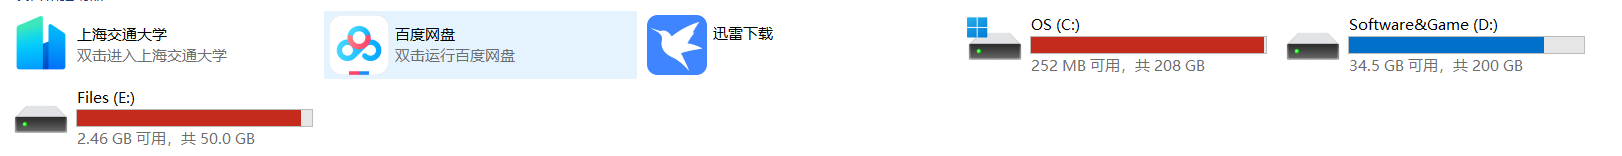

只知道预训练模型在我们测试集上的 ROUGE-1、ROUGE-2、ROUGE-L 值都不高，说明该模型具备文本摘要的能力，但是在“短文本新闻摘要”任务上表现不佳。

# 3. 测试模型
- 汇报在测试集上的 ROUGE-1、ROUGE-2、ROUGE-L 值
- 并且将模型的预测结果保存到文件中

In [ ]:
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False, collate_fn=collote_fn)

import json

model.load_state_dict(torch.load('epoch_1_valid_rouge_6.6667_model_weights.bin'))

model.eval()
with torch.no_grad():
    print('evaluating on test set...')
    sources, preds, labels = [], [], []
    for batch_data in tqdm(test_dataloader):
        batch_data = batch_data.to(device)
        generated_tokens = model.generate(
            batch_data["input_ids"],
            attention_mask=batch_data["attention_mask"],
            max_length=max_target_length,
            num_beams=beam_size,
            no_repeat_ngram_size=no_repeat_ngram_size,
        ).cpu().numpy()
        if isinstance(generated_tokens, tuple):
            generated_tokens = generated_tokens[0]
        label_tokens = batch_data["labels"].cpu().numpy()

        decoded_sources = tokenizer.batch_decode(
            batch_data["input_ids"].cpu().numpy(), 
            skip_special_tokens=True, 
            use_source_tokenizer=True
        )
        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        label_tokens = np.where(label_tokens != -100, label_tokens, tokenizer.pad_token_id)
        decoded_labels = tokenizer.batch_decode(label_tokens, skip_special_tokens=True)

        sources += [source.strip() for source in decoded_sources]
        preds += [pred.strip() for pred in decoded_preds]
        labels += [label.strip() for label in decoded_labels]
    scores = rouge.get_scores(
        hyps=[' '.join(pred) for pred in preds], 
        refs=[' '.join(label) for label in labels], 
        avg=True
    )
    rouges = {key: value['f'] * 100 for key, value in scores.items()}
    rouges['avg'] = np.mean(list(rouges.values()))
    print(f"Test Rouge1: {rouges['rouge-1']:>0.2f} Rouge2: {rouges['rouge-2']:>0.2f} RougeL: {rouges['rouge-l']:>0.2f}\n")
    results = []
    print('saving predicted results...')
    for source, pred, label in zip(sources, preds, labels):
        results.append({
            "document": source, 
            "prediction": pred, 
            "summarization": label
        })
    with open('test_data_pred.json', 'wt', encoding='utf-8') as f:
        for exapmle_result in results:
            f.write(json.dumps(exapmle_result, ensure_ascii=False) + '\n')